##### INF8460 – Traitement automatique de la langue naturelle - Automne 2024
### TP1 - Recherche de documents avec une métrique de similarité


## Identification de l'équipe:

### Groupe de laboratoire:

### Equipe numéro :

### Membres:

- membre 1 (% de contribution, nature de la contribution)
- membre 2 (% de contribution, nature de la contribution)
- membre 3 (% de contribution, nature de la contribution)

* nature de la contribution: Décrivez brièvement ce qui a été fait par chaque membre de l’équipe. Tous les membres sont censés contribuer au développement. Bien que chaque membre puisse effectuer différentes tâches, vous devez vous efforcer d’obtenir une répartition égale du travail. Soyez précis ! N'indiquez pas seulement : travail réparti équitablement

## Mise en place

### Objectif du TP

La recherche d'information est le processus d'accès aux données, généralement des documents ou d'autres données non structurées, à partir d'une requête. Dans ce TP, vous aurez en entrée une requête textuelle sous forme d'affirmation. Il faudra retrouver dans un corpus de littérature scientifique les documents pertinents qui justifient ou infirment la véracité de cette affirmation. Vous utiliserez des modèles vectoriels et des métriques de similarité pour cette tâche.

### Jeux de données

Dans ce TP, vous utiliserez le jeu de données dans le répertoire _data_. Il s'agit d'un ensemble de données comprenant 809 affirmations rédigées par des experts et 5183 documents de références pour ces affirmations. Ces documents contiennent des phrases qui confirment ou infirment (contredisent) les affirmations. L'objectif est donc de trouver un document pertinent, c'est-à-dire contenant la ou les phrases qui permettent d'évaluer une affirmation donnée en entrée en utilisant une similarité sémantique. 

Le jeu de données comprend :

1. Un corpus (_corpus.jsonl_) qui contient des documents décrits avec les informations suivantes :
    - 'doc_id' : permet d'identifier le document en entrée
    - 'title' : donne le titre du document
    - 'abstract': est le résumé du document
    - 'structured': indique si le document est structuré ou pas

2. Un ensemble d'affirmations (_claims.jsonl_) qui contient des documents décrits avec les informations suivantes :
    - 'id' : identifie l'affirmation.
    - 'claim' : est l'affirmation en tant que telle.
    - 'evidence' : précise quelles phrases du document sont pertinentes pour l'affirmation. Chaque phrase est accompagnée d'une étiquette de véracité (confirm/contradict) pour indiquer si la phrase confirme ou contredit l'affirmation.  
    - 'cited_doc_ids' : indique les identifiants des documents cités.



Dans _claims.jsonl_, seuls les identifiants des documents sont renseignés. Pour avoir les détails d'un document tel que le titre ("title") et le résumé ("abstract"), il faudra consulter le fichier _corpus.jsonl_. 

Voici un exemple :

- **Affirmation (claim)** : Consumption of whole fruits increases the risk of type 2 diabetes.
- **Cited document(s) ID(s)** : 1974176
- **Evidence (sentence in the document containing the proof)** : [{'sentences': [11], 'label': 'CONTRADICT'}]

  Ici [11] constitue le numéro de la phrase qui contredit l'affirmation.

- **Cited document(s) title(s)** : Fruit consumption and risk of type 2 diabetes: results from three prospective longitudinal cohort studies
- **Cited document(s) abstract(s) (list of sentences)** : 
    - [0] 'OBJECTIVE To determine whether individual fruits are differentially associated with risk of type 2 diabetes.\n'
    - [1] 'DESIGN Prospective longitudinal cohort study.'
    - ...
    - [10] 'CONCLUSION Our findings suggest the presence of heterogeneity in the associations between individual fruit consumption and risk of type 2 diabetes.'
    - [11] 'Greater consumption of specific whole fruits, particularly blueberries, grapes, and apples, is significantly associated with a lower risk of type 2 diabetes, whereas greater consumption of fruit juice is associated with a higher risk.'

Le champ "evidence" indique la phrase au niveau du résumé du document qui confirme ou infirme l'affirmation, d'où le numéro de la phrase et le label qui y sont renseignés. Dans le cas particulier de l'exemple ci-dessus, on voit bien que la onzième phrase du résumé du document est la plus pertinente pour l'affirmation et qu'elle la contredit, ce qui explique le label "CONTRADICT" dans "evidence". Cependant, dans le cadre de ce TP, on ne s'intéresse qu'à la présence de cette phrase pertinente dans le document, donc on ne considérera pas cette colonne "evidence" dans la suite du TP.

### Librairies permises
- Jupyter notebook
- NLTK
- Numpy 
- Pandas
- Sklearn
- PowerLaw
- Matplotlib
- TQDM
- BM25
- Pour toute autre librairie, demandez à votre chargé de laboratoire

## Étapes du TP
A partir du notebook _INF8460_A24_TP1_ qui est distribué, vous devez réaliser les étapes suivantes. (Notez que les cellules dans le squelette sont là à titre informatif - il est fort probable que vous rajoutiez des sections au fur et à mesure de votre TP).

In [2]:
# Lien vers les fichiers à utiliser
# Ne pas modifier

PATH = 'data/ai2_data/'

In [3]:
# !pip install rank_bm25 
# !pip install powerlaw

In [4]:
# Import des librairies

import numpy as np
import pandas as pd
import powerlaw
from collections import defaultdict, Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import List, Dict

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from string import punctuation

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from rank_bm25 import BM25Okapi

In [5]:
nltk.download('punkt')
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gayamehenni/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gayamehenni/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1. Traitement des données (15 points)
Vous allez effectuer une analyse afin d'avoir une idée claire des données que vous aurez à manipuler.

#### 1.1 Chargement des données (2 points)

##### 1.1.1 Chargement et affichage des données (1 point)

Chargez les données '_claims.jsonl_' et '_corpus.jsonl_' puis affichez-les dans des dataframes en utilisant panda.

In [6]:
# Charger les fichiers dans des dataframes en utilisant les variables `df_claims` et `df_corpus`
df_claims = pd.read_json(PATH+'claims.jsonl', lines=True) 
df_corpus = pd.read_json(PATH+'corpus.jsonl', lines=True)

In [7]:
df_claims.head(n=3)

,id,claim,evidence,cited_doc_ids
0,0,0-dimensional biomaterials lack inductive prop...,{},[31715818]
1,2,1 in 5 million in UK have abnormal PrP positiv...,"{'13734012': [{'sentences': [4], 'label': 'CON...",[13734012]
2,4,1-1% of colorectal cancer patients are diagnos...,{},[22942787]


In [8]:
df_corpus.head(n=3)

,doc_id,title,abstract,structured
0,4983,Microstructural development of human newborn c...,[Alterations of the architecture of cerebral w...,False
1,5836,Induction of myelodysplasia by myeloid-derived...,[Myelodysplastic syndromes (MDS) are age-depen...,False
2,7912,"BC1 RNA, the transcript from a master gene for...",[ID elements are short interspersed elements (...,False


##### 1.1.2 Statistique sur les évidences (1 point)

Calculez les pourcentages d'apparition de chaque label des évidences dans "_df_claims_" (CONTRADICT ou SUPPORT). Pour rappel les évidences sont les extraits pertinents des résumés qui supportent ou contredisent les affirmations. 

In [9]:
# On calcule les pourcentages des labels present dans evidence
evidences = df_claims['evidence'].to_list()
labels = []
list_of_size = []
for evi in evidences:
    for k in evi.keys():
        labels = labels + [evi[k][i]['label'] for i in range(len(evi[k]))]

stats_labels = Counter(labels)

stats_labels_percent = {label: f"{(100 * count / sum(stats_labels.values())):.2f}%" for label, count in stats_labels.items()}
stats_labels_percent

{'CONTRADICT': '35.63%', 'SUPPORT': '64.37%'}

> Réponse attendue:
> 
> CONTRADICT: 35.63%
> 
> SUPPORT: 64.37%

#### 1.2 Analyse statistique des données (7 points)

Nous allons faire une suite de transformations sur les données pour les rendre plus faciles à manipuler.

##### 1.2.1 Implémentation de la fonction "_list_to_string_" 

Nous mettons à votre disposition la fonction "_list_to_string_" qui transforme une liste de phrases en un texte en les concaténant et enlèvant tous les caractères de nouvelle ligne (`\n`) pour s'assurer que nous avons un texte complet. 

In [10]:
# On transforme la liste de phrases en un texte
def list_to_string(x):
    if isinstance(x, list):
        return ' '.join(str(i).replace("\n","").replace("  "," ") for i in x)  # Enlève les caractère de retour à la ligne et convertit les éléments de la liste en chaînes et les joint
    return str(x)

##### 1.2.2 Utilisation de la fonction "_list_to_string_" 

Appliquons cette fonction "_list_to_string_" aux colonnes "_title_" et "abstract" du dataframe "_df_corpus_".

In [11]:
# On applique la fonction aux colonnes "title" et "abstract"
df_corpus['title']    = df_corpus['title'].apply(list_to_string)
df_corpus['abstract'] = df_corpus['abstract'].apply(list_to_string)

##### 1.2.3 Ajout de la colonne "_text_" dans "df_corpus"


Ajoutons maintenant une colonne "_text_" qui est la concaténation du titre ("_title_") et du résumé ("_abstract_") au niveau du dataframe "df_corpus".

In [12]:
# On concatene les textes dans "title" et "abstract"
df_corpus['text'] = df_corpus['title'] + " " + df_corpus['abstract']

##### 1.2.4 Ajout de colonnes dans "_df_claims_" (1 point)

Ajoutez les colonnes "_claim_length_" et "_num_cited_doc_" qui donnent, pour chaque affirmation, le nombre de mots dans la colonne "_claim_" et le nombre de documents cités au niveau de la colonne "_cited_doc_ids_" pour le dataframe "_df_claims_". Vous pouvez considérer que des mots sont simplement une séquence de caractères séparés par un espace.

In [13]:
# On calcule les longueurs des entrées pour chaque colonne
df_claims['claim_length']  = df_claims['claim'].apply(lambda x: len(x.split()))
df_claims['num_cited_doc'] = df_claims['cited_doc_ids'].apply(len)
df_claims.head(n=3)

,id,claim,evidence,cited_doc_ids,claim_length,num_cited_doc
0,0,0-dimensional biomaterials lack inductive prop...,{},[31715818],5,1
1,2,1 in 5 million in UK have abnormal PrP positiv...,"{'13734012': [{'sentences': [4], 'label': 'CON...",[13734012],10,1
2,4,1-1% of colorectal cancer patients are diagnos...,{},[22942787],12,1


##### 1.2.5 Ajout des colonnes de mesures de longeurs de textes (documents) (1 point)

Ajoutez les colonnes "_title_length_", "_abstract_length_" et "_text_length_" qui donnent le nombre de mots dans les colonnes "_title_", "_abstract_" et "_text_" du dataframe "_df_corpus_". Pour le reste du TP, nous définirons la longueur du "_title_", "_abstract_" et du "_text_" comme étant le nombre de mots dans les chaînes de caractères respectives. Encore une fois, vous pouvez considérer que des mots sont simplement une séquence de caractères séparés par un espace.

In [14]:
# On calcule le nombre de mots dans les documents du corpus
df_corpus['title_length']    = df_corpus['title'].apply(lambda x: len(x.split()))
df_corpus['abstract_length'] = df_corpus['abstract'].apply(lambda x: len(x.split()))
df_corpus['text_length']     = df_corpus['text'].apply(lambda x: len(x.split()))
df_corpus.head(n=3)

,doc_id,title,abstract,structured,text,title_length,abstract_length,text_length
0,4983,Microstructural development of human newborn c...,Alterations of the architecture of cerebral wh...,False,Microstructural development of human newborn c...,17,278,295
1,5836,Induction of myelodysplasia by myeloid-derived...,Myelodysplastic syndromes (MDS) are age-depend...,False,Induction of myelodysplasia by myeloid-derived...,7,201,208
2,7912,"BC1 RNA, the transcript from a master gene for...",ID elements are short interspersed elements (S...,False,"BC1 RNA, the transcript from a master gene for...",20,180,200


##### 1.2.6 Analyse statistique (1.5 point)

Faites l'analyse statistique des données en affichant le "_min_", le "_max_" et la "_moyenne_" pour les deux colonnes "_claim_length_" et "_num_cited_doc_" que vous venez de créer.

In [15]:
# On calcule des statistiques pour la colonne "claim" de df_claims
min_claim_length  = df_claims['claim_length'].min()
max_claim_length  = df_claims['claim_length'].max()
mean_claim_length = df_claims['claim_length'].mean()

# On calcule des statistiques pour la colonne "num_cited_doc"
min_num_cited_doc  = df_claims['num_cited_doc'].min()
max_num_cited_doc  = df_claims['num_cited_doc'].max()
mean_num_cited_doc = df_claims['num_cited_doc'].mean()

# On affiche les résultats
print("Statistiques pour la colonne 'claim' de df_claims:")
print(f"Longueur minimale: {min_claim_length}")
print(f"Longueur maximale: {max_claim_length}")
print(f"Longueur moyenne: {mean_claim_length:.2f}")

print("\nStatistiques pour la colonne 'num_cited_doc' df_claims")
print(f"Nombre minimal de documents cités: {min_num_cited_doc}")
print(f"Nombre maximal de documents cités: {max_num_cited_doc}")
print(f"Nombre moyen de documents cités: {mean_num_cited_doc:.2f}")

Statistiques pour la colonne 'claim' de df_claims:
Longueur minimale: 3
Longueur maximale: 39
Longueur moyenne: 12.33

Statistiques pour la colonne 'num_cited_doc' df_claims
Nombre minimal de documents cités: 1
Nombre maximal de documents cités: 5
Nombre moyen de documents cités: 1.14


##### 1.2.7 Histogrammes (2 points)

En considérant le dataframe du corpus de résumés ("_df_corpus_"), affichez dans 3 histogrammes les distributions suivantes:

- Fréquence des titres ('_title_') en fonction de leur longueur
- Fréquence des résumés ('_abstract_') en fonction de leur longueur
- Fréquence des textes ('_text_') en fonction de leur longueur

Utilisez la valeur de 30 pour le paramètre "_bins_"

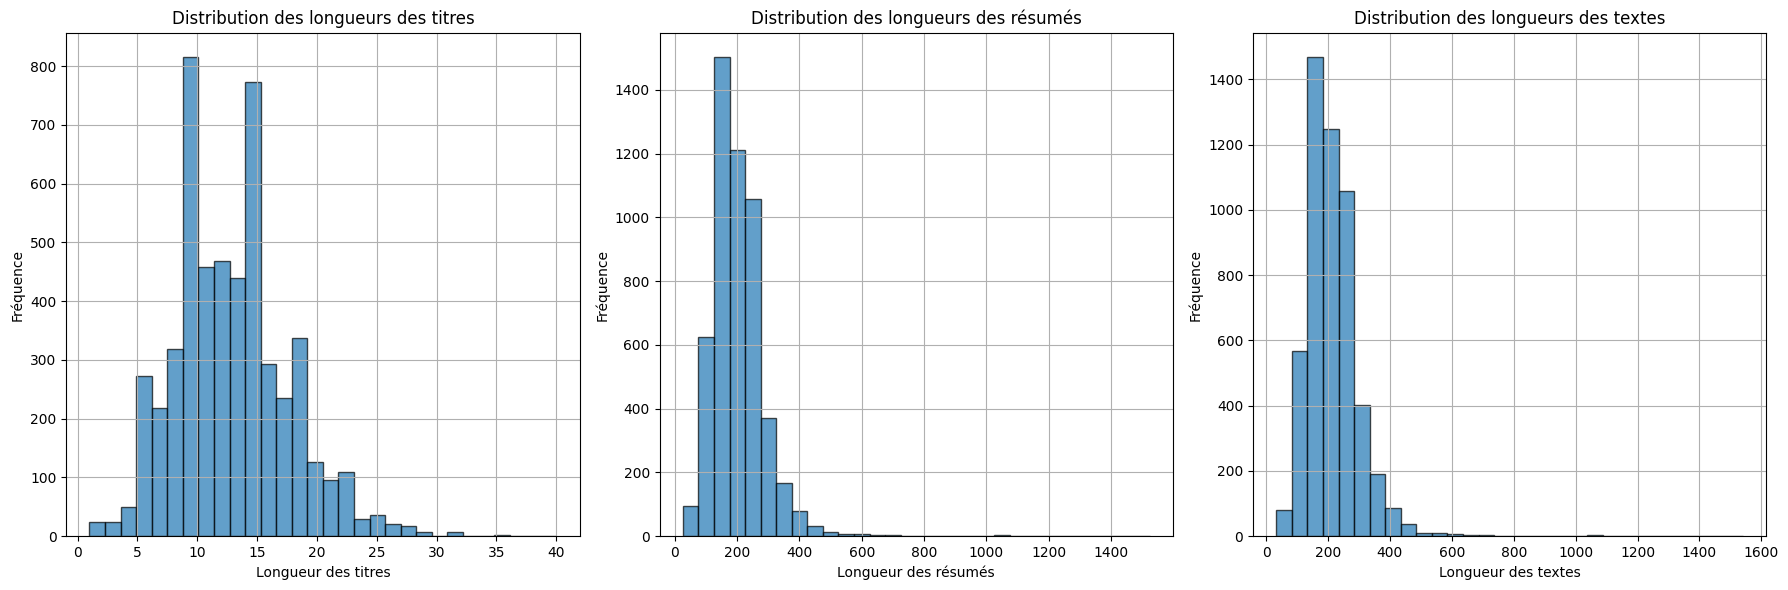

In [16]:
# Création de la figure avec 3 sous-parcelles pour les histogrammes
plt.figure(figsize=(18, 6))

# Histogramme pour les longueurs de "title_length"
plt.subplot(1, 3, 1)
plt.hist(df_corpus['title_length'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution des longueurs des titres')
plt.xlabel('Longueur des titres')
plt.ylabel('Fréquence')
plt.grid(True)

# Histogramme pour les longueurs de "abstract_length"
plt.subplot(1, 3, 2)
plt.hist(df_corpus['abstract_length'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution des longueurs des résumés')
plt.xlabel('Longueur des résumés')
plt.ylabel('Fréquence')
plt.grid(True)

# Histogramme pour les longueurs de "text_length"
plt.subplot(1, 3, 3)
plt.hist(df_corpus['text_length'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution des longueurs des textes')
plt.xlabel('Longueur des textes')
plt.ylabel('Fréquence')
plt.grid(True)

# Affichage des histogrammes
plt.tight_layout()
plt.show()

##### 1.2.8 Quelles remarques faites-vous sur les affirmations (claims) et les documents ? (1.5 points) 

En observant les maximums, les minimums et les moyennes, que remarquez-vous à propos des affirmations ('_claims_') ? À l'aide des graphiques générés, comparez également les documents.

> Réponse attendue: 

    - Les affirmations ne sont pas longues, seulement 12 mots en moyenne.
    - On a en moyenne un seul document cité pour une affirmation.
    - Les titres des documents font en moyenne 10 mots alors que leur résumés en font environ 200.

#### 1.3 Pré-traitement (6 points)
Les affirmations et résumés de texte de votre ensemble de données doivent d’abord être représentés et indexés pour ensuite pouvoir effectuer une recherche de document (pouvant être "_title_", "_abstract_" ou la fusion des deux représentée par "_text_") qui justifie/contredit une affirmation. Vous devez donc implémenter une étape de pré-traitement des données.

##### 1.3.1 Implémentation de la fonction "_tokenize_sentence_" (1 point)

Implémentez la fonction "_tokenize_sentence_" pour la segmentation d'une phrase en une liste de jetons. Utilisez la librarie `nltk`.

In [17]:
# Tokenisation d'une chaine de caractères.
def tokenize_sentence(sentence: str) -> List[str]:
  return word_tokenize(sentence)

##### 1.3.2 Implémentation de la fonction "_tokenize_text_" (1 point)
Implémentez la fonction "_tokenize_text_" qui utilise "_tokenize_sentence_" pour faire la segmentation d'un texte (liste de phrases).

In [18]:
# Segmentation (Tokenization) d'un corpus de plusieurs passages.
def tokenize_text(sentences: List[str]) -> List[List[str]]:
  return [tokenize_sentence(sentence) for sentence in tqdm(sentences)]

##### 1.3.3 Implémentation de la fonction "_stem_tokens_" (1 point)

Implémentez la fonction "_stem_tokens_" qui prend une liste de jetons (tokens) en entrée et retourne une liste contenant leur forme racinisée (stems) en utilisant l'algorithme de racinisation PorterStemmer de la bibliothèque nltk.

In [19]:
# Racinisation d'une liste de jetons.
# def stem_tokens(tokens: List[str]) -> List[str]:
#   stemmer = PorterStemmer()
#   return [stemmer.stem(token) for token in tokens]

def stem_tokens(token):
  stemmer = PorterStemmer()
  return stemmer.stem(token)

##### 1.3.4 Pré-traitement (2 points)

En utilisant vos précédentes fonctions, faites maintenant le pré-traitement des champs "_text_", "_title_" et "_abstract_" du dataframe "_df_corpus_" et "_claim_" du dataframe "_df_claims_" en suivant les étapes suivantes:
- conversion en minuscules
- segmentation (tokenization) des passages
- suppression des stop-words et ponctuation
- racinisation (stemming) des jetons

Nommez la liste des affirmations pré-traitées par "_claims_preprocessed_". Pour le corpus de documents considérez les ensembles de titres "_title_", de résumés "abstract" et la fusion des deux "_text_" et nommez les listes correspondantes par "_titles_preprocessed_", "_abstracts_preprocessed_" et "_texts_preprocessed_" respectivement.

In [20]:
# Segmentation et prétraitement des claims
all_tokenized_claims = tokenize_text(df_claims["claim"].str.lower().tolist())
claims_preprocessed = [
    [stem_tokens(token) for token in claim_tokens if token not in stop_words and token not in punctuation]
    for claim_tokens in all_tokenized_claims
]

# Segmentation et prétraitement des titles
all_tokenized_titles = tokenize_text(df_corpus["title"].str.lower().tolist())
titles_preprocessed = [
    [stem_tokens(token) for token in title_tokens if token not in stop_words and token not in punctuation]
    for title_tokens in all_tokenized_titles
]

# Segmentation et prétraitement des abstracts
all_tokenized_abstracts = tokenize_text(df_corpus["abstract"].str.lower().tolist())
abstracts_preprocessed = [
    [stem_tokens(token) for token in abstract_tokens if token not in stop_words and token not in punctuation]
    for abstract_tokens in all_tokenized_abstracts
]

# Segmentation et prétraitement des texts
all_tokenized_texts = tokenize_text(df_corpus["text"].str.lower().tolist())
texts_preprocessed = [
    [stem_tokens(token) for token in text_tokens if token not in stop_words and token not in punctuation]
    for text_tokens in all_tokenized_texts
]

100%|██████████| 5183/5183 [00:03<00:00, 1426.95it/s]


##### 1.3.5 Jetons uniques (types) (1 point)

Affichez maintenant le nombre total de jetons dans tous les textes (_text_) et affirmations (_claim_) (en les considérant comme un seul corpus) après le pré-traitement. Puis, affichez le nombre de jetons uniques (types) dans les textes (_text_) et les affirmations (_claim_). 

In [21]:
nb_jetons = len([token for sentence in texts_preprocessed + claims_preprocessed for token in sentence])
nb_types  = len(set([token for sentence in texts_preprocessed + claims_preprocessed for token in sentence]))
print(f"Nombre de jetons : {nb_jetons}, nombre de jetons uniques (types): {nb_types}")

Nombre de jetons : 742202, nombre de jetons uniques (types): 45195


### 2. Représentation des affirmations et des documents  (45 points)

#### 2.1  Vocabulaire (15 points)

##### 2.1.1 Implémentation de la fonction "_get_vocab_" (3 points)

Implémentez la fonction "_get_vocab_" qui prend une liste de textes composés chacun d'une liste de jetons et retourne un dictionnaire dont les clés sont les jetons uniques et les valeurs sont leur fréquence dans l'ensemble des textes.

In [22]:
def get_vocab(all_tokens: List[List[str]]) -> Dict[str, int]:
    """
    Construction d'un vocabulaire et des fréquences d'utilisation 
    des jetons sur un corpus de plusieurs passages.
    """
    vocab = Counter(np.concatenate(all_tokens))
    return vocab

##### 2.1.2 Implémentez la fonction "_show_top_N_types_" (3 points)

Implémentez la fonction "show_top_N_types" qui affiche les N jetons les plus fréquents à partir d'un dictionnaire comme celui retourné par la fonction "_get_vocab_".

La fonction prend deux arguments: le dictionnaire "_dictionary_" et le paramètre "_N_". 

In [23]:
# Fonction pour afficher les N types les plus fréquents du corpus.
def show_top_N_types(dictionary: Dict[str, int], N=15):
  freqs = sorted(dictionary.items(), key=lambda x: x[1], reverse=True)
  for freq in freqs[:N]:
    print(freq)

##### 2.1.3 Construction du vocabulaire (1 point)

Construisez maintenant le vocabulaire pour les affirmations et le corpus de documents à partir des listes "texts_preprocessed" et "claims_preprocessed". 

Ensuite affichez les 15 jetons les plus fréquents ainsi que leur fréquence.

In [24]:
vocab = get_vocab(texts_preprocessed + claims_preprocessed)
print(f"Nombre de types composant le vocabulaire: {len(vocab)}")
print("Les 15 types les plus fréquents:")
show_top_N_types(vocab)

Nombre de types composant le vocabulaire: 45195
Les 15 types les plus fréquents:
('cell', 10464)
('patient', 4175)
('activ', 4145)
('studi', 4014)
('use', 3799)
('express', 3626)
('result', 3213)
('protein', 3083)
('gene', 3004)
('cancer', 2945)
('increas', 2794)
('associ', 2659)
('effect', 2567)
('function', 2515)
('human', 2464)


Sortie attendue:

```Nombre de types composant le vocabulaire: 45195
Les 15 types les plus fréquents:
('cell', 10464)
('patient', 4175)
('activ', 4145)
('studi', 4014)
('use', 3799)
('express', 3626)
('result', 3213)
('protein', 3083)
('gene', 3004)
('cancer', 2945)
('increas', 2794)
('associ', 2659)
('effect', 2567)
('function', 2515)
('human', 2464)

##### 2.1.4 Implémentation de la fonction "_show_distribution_" (4 points)

Implémentez la fonction "__show_distribution__" qui permet de visualiser la distribution des fréquences des jetons à partir d'un dictionnaire comme celui retourné par la fonction "_get_vocab_", en utilisant un graphique où l'axe des abscisses représente le rang d'un type (après un tri par ordre de fréquence décroissante) et l'axe des ordonnées représente sa fréquence sur une échelle logarithmique.  

Par exemple, le point (10000, 10) voudrait dire que le 10000ème mot le plus fréquent a une fréquence à peu prés egale à 10 dans le vocabulaire.

In [25]:
# Fonction show_distribution pour faire le plot dans un graphe
def show_distribution(vocab: Dict[str, int]):
  points = sorted(vocab.items(), key=lambda x:x[1], reverse=True)
  X, Y = zip(*points)
  plt.plot(np.arange(len(X)), Y)
  plt.xlabel("Rang du type dans le vocabulaire")
  plt.ylabel("Fréquence")
  plt.yscale("log")
#   plt.xscale("log")
  plt.title("Distribution des fréquences en fonction du nombre de types du vocabulaire")
  plt.show()

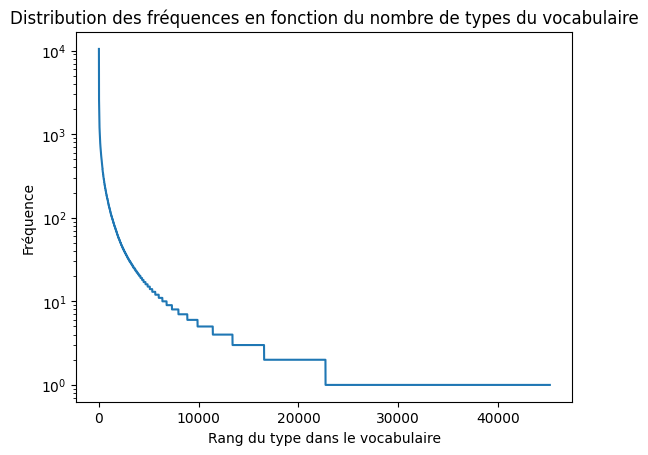

In [26]:
show_distribution(vocab)

##### 2.1.5 Vérification de la loi de Zipf (4 points)

Afin de vérifier la loi de Zipf, donnez une estimation de la valeur de la constante k de cette loi définie comme suit: 

$$ f \approx \frac{k}{r^\alpha} $$ 

où $ f $ est la fréquence d'un mot, $ r $ est le rang de ce mot dans la liste triée par fréquence décroissante, et $ k $ est une constante. Etant données les fluctuations sur les valeurs de fréquence, vous pouvez utiliser la librairie ['powerlaw'](https://pypi.org/project/powerlaw/) conçue pour analyser et ajuster des distributions de loi de puissance aux données et qui peut être utile dans l'estimation de $ \alpha $.

Affichez la constante $ k $ trouvée, les fréquences réelles des mots avec celles qui sont prédites par la loi de Zipf.

2min progress: 99%

Zipf

Estimated alpha: 1.0000
Estimated k: 47752.4394

LINEAR

Estimated alpha: 1.3309
Estimated k: 1111077.4750

Using first point

Estimated alpha: 1.6618
Estimated k: 10464

MEAN

Estimated alpha: 1.6618
Estimated k: 28935528.8903

MEDIAN

Estimated alpha: 1.6618
Estimated k: 26035754.9282


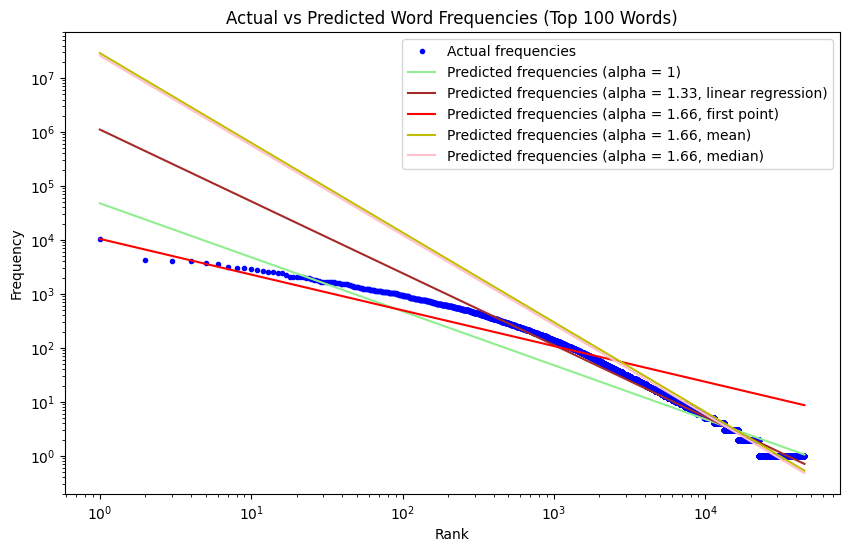

In [43]:
import numpy as np

frequencies = sorted(vocab.values(), reverse=True)
ranks = np.arange(1, len(frequencies) + 1)

# Fit the data to a power law
fit = powerlaw.Fit(frequencies, discrete=True, verbose=0)

# Estimate the exponent
alpha_fit = fit.power_law.alpha
xmin = int(fit.power_law.xmin)

print(xmin)

# ============================ Without powerlaw with alpha = 1 ============================

print('\n', '=' * 100, sep='')
print('Zipf')
print('=' * 100, '\n')

# Calculate K using the assumption that a = 1
alpha = 1
k = frequencies * (ranks ** alpha) 
k = k.mean()

print(f"Estimated alpha: {alpha:.4f}")
print(f"Estimated k: {k:.4f}")

# Calculate the estimated frequencies using a = 1
predicted_frequencies_zipf = [k / (r ** (alpha)) for r in ranks]

# ============================ Without powerlaw with alpha != 1 (Liner regression) ============================


print('\n', '=' * 100, sep='')
print('LINEAR')
print('=' * 100, '\n')

x = np.log(np.array(ranks))
y = np.log(np.array(frequencies))
avg_x = np.mean(x)
avg_y = np.mean(y)
alpha_linear = -np.sum((x - avg_x) * (y - avg_y)) / np.sum((x - avg_x) ** 2)
k = frequencies * (ranks ** alpha_linear)
k_linear = k.mean()

print(f"Estimated alpha: {alpha_linear:.4f}")
print(f"Estimated k: {k_linear:.4f}")

predicted_frequencies_linear = [k_linear / (r ** (alpha_linear)) for r in ranks]


# ============================ With powerlaw with alpha != 1 (Using first point) ============================

print('\n', '=' * 100, sep='')
print('Using first point')
print('=' * 100, '\n')

# Estimate k with first
k = frequencies[0] * ranks[0] ** (alpha_fit - 1)

print(f"Estimated alpha: {alpha_fit:.4f}")
print(f"Estimated k: {k:.0f}")

# Predict frequencies using Zipf's law with the fitted alpha
predicted_frequencies_first = [k / (r ** (alpha_fit - 1)) for r in ranks]

# ============================ With powerlaw with alpha != 1 (Average K) ============================

print('\n', '=' * 100, sep='')
print('MEAN')
print('=' * 100, '\n')

k_mean = np.array(
    [frequency*(rank**alpha_fit) for frequency, rank in zip(frequencies[xmin:], ranks[xmin:])]
).mean()

predicted_frequencies_mean = [k_mean / (r ** (alpha_fit)) for r in ranks]
print(f"Estimated alpha: {alpha_fit:.4f}")
print(f"Estimated k: {k_mean:.4f}")

# ============================ With powerlaw with alpha != 1 (Median K) ============================

print('\n', '=' * 100, sep='')
print('MEDIAN')
print('=' * 100, '\n')

k_median = np.median(np.array(
    [frequency*(rank**alpha_fit) for frequency, rank in zip(frequencies[xmin:], ranks[xmin:])]
))

predicted_frequencies_median = [k_median / (r ** (alpha_fit)) for r in ranks]
print(f"Estimated alpha: {alpha_fit:.4f}")
print(f"Estimated k: {k_median:.4f}")

# ============================ Show frequencies ============================

plt.figure(figsize=(10, 6))
plt.loglog(ranks, frequencies, 'b.', label='Actual frequencies')
plt.loglog(ranks, predicted_frequencies_zipf, 'lightgreen', label=f'Predicted frequencies (alpha = {1})')
plt.loglog(ranks, predicted_frequencies_linear, 'brown', label=f'Predicted frequencies (alpha = {alpha_linear:.2f}, linear regression)')
plt.loglog(ranks, predicted_frequencies_first, 'r', label=f'Predicted frequencies (alpha = {alpha_fit:.2f}, first point)')
plt.loglog(ranks, predicted_frequencies_mean, 'y', label=f'Predicted frequencies (alpha = {alpha_fit:.2f}, mean)')
plt.loglog(ranks, predicted_frequencies_median, 'pink', label=f'Predicted frequencies (alpha = {alpha_fit:.2f}, median)')
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.legend()
plt.title('Actual vs Predicted Word Frequencies (Top 100 Words)')
plt.show()


#### 2.2  Création d’un modèle sac de mots (10 points)

##### 2.2.1 Répresentation de texte (5 points)

En utilisant sklearn et à partir de vos données pré-traitées ("_claims_preprocessed_", "_titles_preprocessed_", "_abstracts_preprocessed_" et "_texts_preprocessed_"), représentez chaque affirmation (_claim_) et document avec le vocabulaire créé 'précédemment dans la variables "_claims_preprocessed_joined", "_titles_preprocessed_joined_", "_abstract_preprocessed_joined_" et "_texts_preprocessed_joined_". Cela veut dire que tout jeton qui n'est pas dans le vocabulaire doit être enlevé dans le document et l'affirmation. Faites cela pour les trois possibilités de représentation de document: "_title_", "_abstract_" et "_text_".

In [94]:
"""
  On utilise les ensembles pré-traités et on ne conserve que les
  jetons appartenant au vocabulaire.
"""
# Pretraitement pour les claims
claims_preprocessed_joined = []
for claim_tokens in tqdm(claims_preprocessed):
  claims_preprocessed_joined.append(" ".join([token for token in claim_tokens if token in vocab]))


# Pretraitement pour les documents ('title', 'abstract' ou 'text')
texts_preprocessed_joined = []
for text_tokens in tqdm(texts_preprocessed):
  texts_preprocessed_joined.append(" ".join([token for token in text_tokens if token in vocab]))
  
titles_preprocessed_joined = []
for title_tokens in tqdm(titles_preprocessed):
  titles_preprocessed_joined.append(" ".join([token for token in title_tokens if token in vocab]))

abstracts_preprocessed_joined = []
for abstract_tokens in tqdm(abstracts_preprocessed):
  abstracts_preprocessed_joined.append(" ".join([token for token in abstract_tokens if token in vocab]))

100%|██████████| 5183/5183 [00:00<00:00, 65132.50it/s]


##### 2.2.2 Pondération (4 points)

En utilisant un modèle sac de mots basé sur des unigrammes et des bigrammes, créez une représentation vectorielle de vos documents (titles, abstracts, texts) et de vos affirmations (claims) avec TF-IDF en utilisant le TfidfVectorizer de sklearn. 

In [95]:
#  On procède par la transformation des ensembles en sac de mots pondérés.
vectorizer  = TfidfVectorizer(ngram_range=(1,2))  
vectorizer.fit(texts_preprocessed_joined + claims_preprocessed_joined)

final_claims = vectorizer.transform(claims_preprocessed_joined)
final_texts = vectorizer.transform(texts_preprocessed_joined)
final_titles = vectorizer.transform(titles_preprocessed_joined)
final_abstracts = vectorizer.transform(abstracts_preprocessed_joined)

##### 2.2.3 Affichage (1 point)

Affichez les dimensions (shape) de vos corpus (claims, text, title, abstract) après vectorisation

In [96]:
print(final_claims.shape)

(809, 473643)


Sortie attendue pour "_claims_"
```
(809, 473643)
```

In [97]:
print(final_texts.shape)

(5183, 473643)


Sortie attendue pour "_texts_"
```
(5183, 473643)
```

In [98]:
print(final_titles.shape)

(5183, 473643)


Sortie attendue pour "_titles_"
```
(5183, 473643)
```

In [99]:
print(final_abstracts.shape)

(5183, 473643)


Sortie attendue pour abstracts
```
(5183, 473643)

#### 2.3 Pertinence d'un document (20 points)

Maintenant que vous avez une représentation de vos affirmations "_claims_" et documents ("_texts_", "_titles_", "_abstracts_"), il faut être capable de déterminer quel document sera le plus pertinent pour une affirmation donnée.

##### 2.3.1 Implémentation de "_eval_similarity_" (3 points)

Implémentez la fonction "_eval_similarity_" pour évaluer la similarité cosinus entre la représentation de l'affirmation et celle de chaque document. La fonction prend une liste d'affirmations et une liste de documents et retourne une matrice où chaque ligne représente une affirmation et chaque colonne représente un document ("title", "abstract" ou "text") et les valeurs sont les similarités cosinus entre une affirmation et un document.

In [100]:
# Fonction de calcul de la similarite cosinus
def eval_similarity(claims, texts):
    similarities = cosine_similarity(claims, texts)
    return similarities

##### 2.3.2 Implémentation de la fonction "_rank_texts_" (2 points)

Implémentez la fonction "_rank_texts_", qui, au moyen de la précédente (_eval_similarity_), retourne le top-N (N=1,3,5) des documents pertinents pour une affirmation donnée (N est un paramètre). Ces documents devront être ordonnés du plus pertinent au moins pertinent. Idéalement, le document à la position 1 sera celui qui contient la preuve (ou justification) de l'affirmation. Il faudra retourner non pas les indices des documents dans le dataframe mais plutôt leur identifiants au niveau de la colonne "_doc_id_".

In [101]:
# Fonction pour retourner les top-N "documents" les plus pertinents à un ensemble de "claims".
def rank_texts(claims, corpus, df_corpus: pd.DataFrame, N: int):
    similarities = eval_similarity(claims, corpus)
    indexes = np.argsort(-similarities, axis=1)[:, :N]
    
    # Mapper les indices aux "doc_id" à partir de df_corpus
    doc_ids = df_corpus['doc_id'].values 
    results = np.array([doc_ids[row_indexes] for row_indexes in indexes])
    
    return results

##### 2.3.3 Préparation des dataframes de réponses (1 point) 

Vous allez écrire la fonction "prepare_results_df" qui crée les dataframes qui vont contenir les résultats de la recherche de documents pertinents pour les affirmations.

La fonction "prepare_results_df" prend les arguments suivants:

- '_df_': le dataframe original nommé '_df_claims_' à partir duquel on crée les autres, 
- '_columns_to_drop_': les colonnes à supprimer 
- '_column_to_rename_': le nom de la colonne de référence dans le dataframe original qui sera renommée "gold standard passage"

et effectue les opérations suivantes:

1. Créer un nouveau dataframe à partir de "_df_claims_" en supprimant toutes les colonnes sauf "cited_doc_ids".
2. Renommer la colonne "cited_doc_ids" en "gold standard passage".
3. Ajouter les colonnes "top_1", "top_3", et "top_5" au dataframe, 
en les initialisant avec des chaînes de zéros séparés par des points-
virgules, correspondant respectivement à des configurations de 1, 3, et 
5 zéros pour toutes les lignes.

Vous utiliserez ensuite cette fonction pour créer les dataframes "results_titles_df", "results_abstracts_df" et "results_texts_df", qui seront destinés à contenir les résultats de recherche de documents pour "title", "abstract" et "text" respectivement.

In [102]:
def prepare_results_df(df, columns_to_drop, column_to_rename):
    results_df = df.drop(columns_to_drop, axis=1).rename(columns={column_to_rename: "gold standard passage"})
    for top_n in [1, 3, 5]:
        results_df[f"top_{top_n}"] = [";".join(["0"] * top_n)] * results_df.shape[0]
    return results_df

columns_to_drop = ["claim", "evidence", "claim_length", "num_cited_doc"]
column_to_rename = "cited_doc_ids"

results_titles_df    = prepare_results_df(df_claims, columns_to_drop, column_to_rename)
results_abstracts_df = prepare_results_df(df_claims, columns_to_drop, column_to_rename)
results_texts_df     = prepare_results_df(df_claims, columns_to_drop, column_to_rename)

> Sortie attendue pour chaque dataframe préparé
<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>id</th>
      <th>gold standard passage</th>
      <th>top_1</th>
      <th>top_3</th>
      <th>top_5</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0</td>
      <td>[31715818]</td>
      <td>0</td>
      <td>0;0;0</td>
      <td>0;0;0;0;0</td>
    </tr>
    <tr>
      <th>1</th>
      <td>2</td>
      <td>[13734012]</td>
      <td>0</td>
      <td>0;0;0</td>
      <td>0;0;0;0;0</td>
    </tr>
    <tr>
      <th>2</th>
      <td>4</td>
      <td>[22942787]</td>
      <td>0</td>
      <td>0;0;0</td>
      <td>0;0;0;0;0</td>
    </tr>
  </tbody>
</table>
</div>

##### 2.3.4 Implémentation de la fonction "_fill_results_" (2 points)

Vous devez maintenant implémenter la fonction "_fill_results_" qui remplit les dataframes préparés dans l'étape précédente en utilisant les resultats de recherche de document.
Cette fonction prend les arguments suivant: 
- "_results_" : matrice contenant les valeurs de similarite des affirmations et des documents
- "_results_texts_df_" : Dataframe contenant les affirmations ainsi que les colonnes "top_1", "top_3", "top_5" où doivent être mis les top-n documents les plus pertinents.

Les deux arguments contiennent le même nombre d'éléments et pour le même indice, font référence à la même affirmation.

In [103]:
# Fonction pour créer un dataframe contenant les resultats à des fins de facilité d'évaluation des résulats

def fill_results(results, results_texts_df):
    """
    - results               : matrice contenant les valeurs de similarite des affirmations et des documents
    - results_texts_df      : Dataframe contenant les affirmations ainsi que les colonnes "top_1", "top_3", "top_5" 
    oú doivent être mis les top-n documents les plus similaires. 
    Les deux arguments contiennent le même nombre de d'éléments et pour le même indice, font référence à la même affirmation.
    """
    for i, result in enumerate(tqdm(results)):
        # Modifier ici pour limiter les colonnes traitées
        for col in [col for col in results_texts_df.columns[-4:] if 'top_' in col]:
            try:
                results_texts_df.loc[i, col] = ";".join(result[:int(col[4:])].astype(int).astype(str))
            except Exception as e:
                print(f"Error processing row {i}, column {col}: {e}")

##### 2.3.5 Exécution des fonctions "_rank_texts_" et fill_results(2 points)

Exécutez maintenant votre fonction "_rank_texts_" sur toutes les affirmations (claims) et toutes les représentations de documents (title, abstract, text) en mettant les résultats dans les variables "results_texts", "results_titles" et "results_abstracts". Ensuite appelez la fonction "_fill_results_" qui remplit les dataframes "_results_titles_df_", "_results_abstracts_df_", et "_results_texts_df_" contenant les résultats de recheche de documents.

In [104]:
results_texts = rank_texts(final_claims, final_texts,df_corpus, 5)
fill_results(results_texts, results_texts_df)

results_titles = rank_texts(final_claims, final_titles,df_corpus, 5)
fill_results(results_titles, results_titles_df)

results_abstracts = rank_texts(final_claims, final_abstracts,df_corpus, 5)
fill_results(results_abstracts, results_abstracts_df)

100%|██████████| 809/809 [00:00<00:00, 6427.17it/s]


In [105]:
results_texts_df 

,id,gold standard passage,top_1,top_3,top_5
0,0,[31715818],10608397,10608397;42421723;10607877,10608397;42421723;10607877;21257564;35008773
1,2,[13734012],13734012,13734012;17333231;13770184,13734012;17333231;13770184;42240424;3716075
2,4,[22942787],7165938,7165938;1387104;520579,7165938;1387104;520579;10958594;52188256
3,6,[2613775],23117378,23117378;2613775;21050357,23117378;2613775;21050357;20240998;35521287
4,9,[44265107],44265107,44265107;24700152;14647747,44265107;24700152;14647747;26105746;25182647
...,...,...,...,...,...
804,1403,"[33370, 38355793]",33370,33370;38355793;45764440,33370;38355793;45764440;40412980;7986878
805,1404,"[33370, 38355793]",38355793,38355793;33370;45764440,38355793;33370;45764440;40412980;7986878
806,1405,[10504681],20402596,20402596;10504681;38675228,20402596;10504681;38675228;5849439;14926162
807,1406,[2617858],2617858,2617858;4465762;4857085,2617858;4465762;4857085;10577574;13963620


##### 2.3.6 Enregistrement des dataframes 

On enregistre les dataframes dans des fichiers .csv.

In [106]:
results_texts_df.to_csv("results_texts.csv", index=False)
results_titles_df.to_csv("results_titles.csv", index=False)
results_abstracts_df.to_csv("results_abstracts.csv", index=False)

##### 2.3.7 Implémentation de la fonction "_show_top_n_passages_" (3 points)

Vous devez maintenant implémenter une fonction "_show_top_n_passages_" qui affiche le top-n ainsi que le texte (document) attendu pour une affirmation donnée. Ici on considère que document est representé par "_text_" donc la fusion du titre ("_title_") et du résumé ("_abstract_")

In [107]:
def show_top_n_passages(example_id, results, df_corpus, n):
    """
    Affiche les top_n passages les plus similaires d'une affirmation

    example_id  : Id de l'affirmation
    results     : Dataframe contenant les résultats de prédictions
    df_corpus   : Corpus de documents contenant les documents ainsi que leur id respectifs
    n           : Nombre de documents à afficher
    """
    print("claim:", df_claims["claim"].values[example_id])
    print("~"*100)
    print(df_claims["id"].values[example_id])
    correct_ids  = df_claims["cited_doc_ids"].values[example_id]
    print(f"correct_ids for the texts: {correct_ids}")
    print("~"*100)

    for i, correct_id in enumerate(correct_ids):
        print("Expected text ", i+1, ": ", df_corpus.loc[df_corpus["doc_id"] == correct_id, 'text'].iloc[0])
    print("~"*100)

    ids = results[example_id]
    print(f"Predicted texts ids for the claim: {ids}")
    # print(len(ids), corpus_df.shape[0])
    for i, id in enumerate(ids[:n]):
        text = df_corpus.loc[df_corpus["doc_id"] == id, 'text'].iloc[0]
        for correct_id in correct_ids:
            if correct_id == id:
                print("***", end="")
            else:
                print("   ", end="")
        print(f"Top-{i+1} -->", text)
        print()
    print("~"*100)

    rangs = [i+1 for i, elem in enumerate(ids) if elem in correct_ids]
    if not rangs:
        print(f"L'affirmation ne correspond à aucun des top-{n} textes retrouvés")
    else:
        print(f"L'affirmation correspond au documment de rang {rangs[0]} parmi les top-{n} textes retrouvés")

##### 2.3.8 Affichage (1 point)

Appliquez cette fonction sur l'affirmation ayant pour identifiant 211 et affichez le top-5 des documents les plus pertinents retrouvés.

In [108]:
example_id = 125
print(f"ID of the claim picked: {example_id}")
show_top_n_passages(example_id, results_texts, df_corpus, 5)

ID of the claim picked: 125
claim: COPI coatmer is involved in viral replication.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
211
correct_ids for the texts: [13794374]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Expected text  1 :  COPI Complex Is a Regulator of Lipid Homeostasis Lipid droplets are ubiquitous triglyceride and sterol ester storage organelles required for energy storage homeostasis and biosynthesis. Although little is known about lipid droplet formation and regulation, it is clear that members of the PAT (perilipin, adipocyte differentiation related protein, tail interacting protein of 47 kDa) protein family coat the droplet surface and mediate interactions with lipases that remobilize the stored lipids. We identified key Drosophila candidate genes for lipid droplet regulation by RNA interference (RNAi) screening with an image segmentation-based optical read-

##### 2.3.9 Évaluation (3 points)

Vous devez maintenant implémenter la fonction "_evaluate_" qui, à partir des colonnes *Gold standard passage* et de vos top-N respectifs, calcule la précision top-N (N=1,3,5) sur l’ensemble de données en paramètre et l’affiche. 

Cette précision connue sous le nom "precision at k (precision@k)" se calcule de la manière suivante:


$$
\text{precision@k} = \frac{\text{nombre d'éléments corrects}}{\text{nombre total d'éléments k retrouvés}}
$$


Veillez à ce que la fonction soit générique. 

In [109]:
def evaluate(results_texts_df):
    precision = {top: 0 for top in results_texts_df.columns[-3:]}
    for i in range(results_texts_df.shape[0]):
        for top in precision:
            # Récupérer la liste des passages corrects pour l'entrée courante
            correct_ids = results_texts_df.loc[i, "gold standard passage"]
            correct_ids = [str(id) for id in correct_ids]

            # Récupérer les passages prédits jusqu'à top-k
            retrieved = results_texts_df.loc[i, top]
            retrieved_ids = str(retrieved).split(";") if isinstance(retrieved, str) else [str(retrieved)]

            # Calculer le nombre de résultats pertinents parmi les k premiers
            relevant_hits = sum(1 for retrieved_id in retrieved_ids if retrieved_id in correct_ids)

            # Calculer la précision@k
            precision[top] += relevant_hits / len(retrieved_ids) if len(retrieved_ids) > 0 else 0 

    # Moyenne sur tous les exemples
    for top in precision:
        precision[top] = precision[top] / results_texts_df.shape[0]

    return precision

##### 2.3.10 Affichage (1 point)

Appliquez cette fonction pour calculer la précision des documents retrouvés en utilisant les titres ("_title_"), les résumés ("_abstract_") et la fusion des deux ("_text_").

In [110]:
# Évaluer et afficher la précision pour les textes
precision_text = evaluate(results_texts_df)
print(f"Précision avec 'text': {precision_text}")

# Évaluer et afficher la précision pour les titres
precision_titles = evaluate(results_titles_df)
print(f"Précision avec 'title': {precision_titles}")

# Évaluer et afficher la précision et les résumés
precision_abstracts = evaluate(results_abstracts_df)
print(f"Précision avec 'abstract': {precision_abstracts}")

Précision avec 'text': {'top_1': 0.48702101359703337, 'top_3': 0.22538112896580223, 'top_5': 0.15203955500618185}
Précision avec 'title': {'top_1': 0.3226205191594561, 'top_3': 0.1635764318088168, 'top_5': 0.1117428924598278}
Précision avec 'abstract': {'top_1': 0.46600741656365885, 'top_3': 0.21672847136382423, 'top_5': 0.14388133498145989}


##### 2.3.11 Graphique (2 points)

Tracez un graphique des valeurs de précisions des documents retrouvés ("__title__", "__abstract__", "__text__") pour différents N (1,3,5).

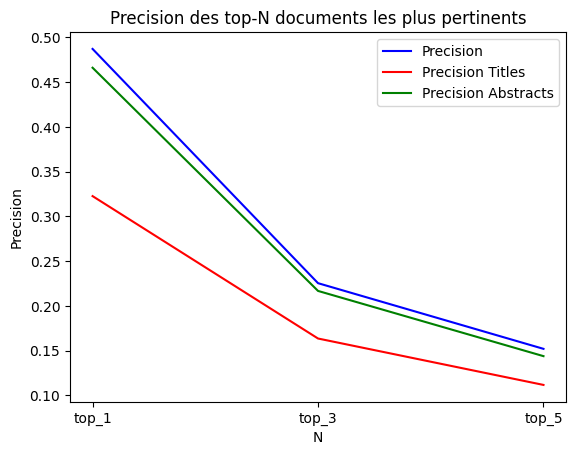

In [111]:
# Tracer les valeurs de chaque dictionnaire avec des couleurs différentes
plt.plot(list(precision_text.keys()), list(precision_text.values()), label='Precision', color='blue')
plt.plot(list(precision_titles.keys()), list(precision_titles.values()), label='Precision Titles', color='red')
plt.plot(list(precision_abstracts.keys()), list(precision_abstracts.values()), label='Precision Abstracts', color='green')

# Ajouter des étiquettes et un titre
plt.xlabel("N")
plt.ylabel("Precision")
plt.title("Precision des top-N documents les plus pertinents")

# Ajouter une légende pour identifier les courbes
plt.legend()

# Afficher le graphique
plt.show()

### 3 Amélioration avec BM25 (20 points)

BM25 (Best Matching 25) est un algorithme de recherche utilisé pour évaluer la pertinence des documents par rapport à une requête. Basé sur le modèle de récupération d'informations probabilistes, BM25 calcule un score de pertinence en tenant compte de la fréquence des termes de la requête dans chaque document et dans le corpus global mais aussi de la longueur des documents. 

BM25 est pertinent pour la recherche d'information car il offre un bon équilibre entre précision et rappel, il gère efficacement de grandes collections de documents et permet des ajustements pour différents types de corpus. Il est largement utilisé dans les moteurs de recherche et les systèmes de recommandation.

Dans cette partie on vous demande de la tester au moyen de la librairie rank_bm25 pour cette tâche de recherche de texte qui justifie ou contredit une affirmation donnée. Vous allez utiliser le corpus et les affirmations et procéder comme indiqué dans la suite.

##### 3.1 Initialisation du modèle BM25 (3 points)
Réutilisez les variables "claims_preprocessed_joined", "texts_preprocessed_joined", "titles_preprocessed_joined" et "abstract_preprocessed_joined" définies à la question `2.2.1` pour initialiser les modèles BM25 pour les documents ("__titles__", "__abstracts__" et "__text__"). Il faudra transformer chaque séquence (dont les jetons étaient joints pour former une seule chaîne) en une liste de jetons. Vous utiliserez la classe "_BM250kapi_" à ce niveau. 

In [113]:
"""
Les paramètre b et k1:
    - Les valeurs par défaut sont: b=0.75 and k1=1.2
    - b amplifie/atténue l'effet de la différence de taille d'un document comparé à la moyenne des tailles des documents
    - k1 permet de determiner la saturation d'un terme de la requête ie il nous permet de limiter l'effet qu'un terme peut avoir sur le score d'un document
"""
bm25_texts     = BM25Okapi([seq.split() for seq in texts_preprocessed_joined]) 
bm25_titles    = BM25Okapi([seq.split() for seq in titles_preprocessed_joined]) 
bm25_abstracts = BM25Okapi([seq.split() for seq in abstracts_preprocessed_joined]) 

##### 3.2 Utilisation du modèle BM25 (5 points)

Retrouvez les identifiants des documents pour les cinq meilleures correspondances de "_title_", de "_abstract_" et de "_text_" en utilisant le score BM25 pour chaque affirmation (claim) traitée, et mettez à jour les résultats avec les identifiants de documents correspondants.

In [114]:
bm25_results_titles, bm25_results_abstracts, bm25_results_texts = [], [], []

# Tableau contenant chacun des mots des affirmations
claims_bm25 = [seq.split() for seq in claims_preprocessed_joined]

# Titles
for claim in tqdm(claims_bm25):
    scores = bm25_titles.get_scores(claim)
    bm25_results_titles.append(np.argsort(-scores)[:5])

# Abstracts
for claim in tqdm(claims_bm25):
    scores = bm25_abstracts.get_scores(claim)
    bm25_results_abstracts.append(np.argsort(-scores)[:5])

# Texts
for claim in tqdm(claims_bm25):
    scores = bm25_texts.get_scores(claim)
    bm25_results_texts.append(np.argsort(-scores)[:5])

doc_ids = df_corpus['doc_id'].values # recupérer les identifiants à partir de df_corpus
results_titles    = np.array([doc_ids[row_indexes] for row_indexes in bm25_results_titles])
results_abstracts = np.array([doc_ids[row_indexes] for row_indexes in bm25_results_abstracts])
results_texts     = np.array([doc_ids[row_indexes] for row_indexes in bm25_results_texts])

bm25_results_titles = results_titles
bm25_results_abstracts = results_abstracts
bm25_results = results_texts

100%|██████████| 809/809 [00:05<00:00, 143.40it/s]


##### 3.3 Affichage des performances (4 points)

Affichez les résultats des performances BM25 pour les configurations Top1, Top3 et Top5 avec "_title_", "_asbtract_" et "_text_".

In [115]:
# Titles
bm_25_df_titles = results_texts_df.copy()
fill_results(bm25_results_titles, bm_25_df_titles)
perf_bm25_titles = evaluate(bm_25_df_titles)
print(f"Performance avec 'title': {perf_bm25_titles}")

# Abstracts
bm_25_df_abstract = results_texts_df.copy()
fill_results(bm25_results_abstracts, bm_25_df_abstract)
perf_bm25_abstracts = evaluate(bm_25_df_abstract)
print(f"Performance avec 'abstract': {perf_bm25_abstracts}")

# Texts
bm_25_df_texts = results_texts_df.copy()
fill_results(bm25_results, bm_25_df_texts)
perf_bm25 = evaluate(bm_25_df_texts)
print(f"Performance avec 'text': {perf_bm25}")

100%|██████████| 809/809 [00:00<00:00, 5343.57it/s]


Performance avec 'title': {'top_1': 0.3226205191594561, 'top_3': 0.147507210548001, 'top_5': 0.09864029666254698}


100%|██████████| 809/809 [00:00<00:00, 5818.30it/s]


Performance avec 'abstract': {'top_1': 0.553770086526576, 'top_3': 0.23444581788216, 'top_5': 0.15673671199011271}


100%|██████████| 809/809 [00:00<00:00, 5909.93it/s]


Performance avec 'text': {'top_1': 0.5673671199011124, 'top_3': 0.23939019365471884, 'top_5': 0.1582200247218803}


##### 3.4 Graphique (4 points)

Dans un même graphique, affichez les performances pour les deux modèles (TF-IDF et BM25) dans la recherche des documents (text, title et abstract) pour les affirmations.

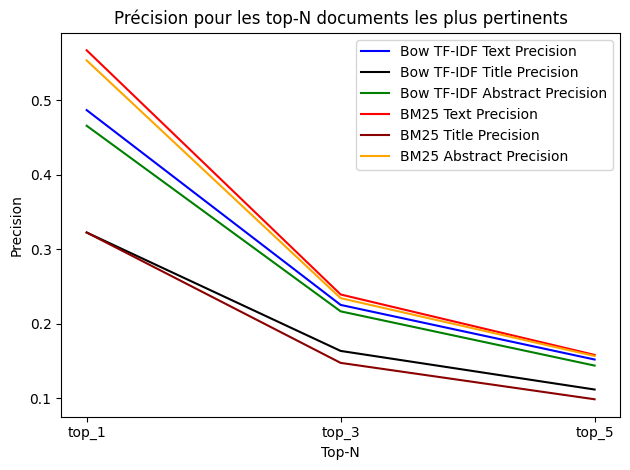

In [116]:
# Créer une figure 
list_keys = precision_text.keys()
plt.plot(list_keys, [precision_text[top] for top in list_keys], label='Bow TF-IDF Text Precision', color='blue')
plt.plot(list_keys, [precision_titles[top] for top in list_keys], label='Bow TF-IDF Title Precision', color='black')
plt.plot(list_keys, [precision_abstracts[top] for top in list_keys], label='Bow TF-IDF Abstract Precision', color='green')

# Ajouter les performances BM25
plt.plot(list_keys, [perf_bm25[top] for top in list_keys], label='BM25 Text Precision', color='red')
plt.plot(list_keys, [perf_bm25_titles[top] for top in list_keys], label='BM25 Title Precision', color='darkred')
plt.plot(list_keys, [perf_bm25_abstracts[top] for top in list_keys], label='BM25 Abstract Precision', color='orange')

plt.xlabel("Top-N")
plt.ylabel("Precision")
plt.title("Précision pour les top-N documents les plus pertinents")
plt.legend()

# Afficher la figure contenant les deux graphiques
plt.tight_layout()
plt.show()

##### 3.5 Observation (4 points)

Par rapport à vos résultats avec TF-IDF, observez-vous une amélioration ou une détérioration des performances, qu'est ce qui explique cela ? (Donnez au moins trois justifications)

> Réponses possibles:

- Observations: On a une meilleure performance qu'avec le modèle BOW

- Justifications:
    - Normalisation par la longueur : BM25 normalise la longueur des documents, équilibrant ainsi les termes entre documents longs et courts.
    - Pondération non linéaire des termes fréquents : La saturation de la fréquence des termes dans BM25 réduit l'impact des termes extrêmement fréquents.
    - Facteur de correction de longueur : Le paramètre b ajuste l'importance de la normalisation de la longueur, améliorant la personnalisation.
    - Pondération dynamique : BM25 offre une pondération flexible basée sur la fréquence des termes et leur importance relative.

## Livrables
Vous devez remettre votre notebook sur Moodle et Gradescope en prenant le soin d'associer les numéros de questions avec vos réponses dans le rapport (fichier .pdf) grâce à l'outil que fournit Gradescope.


## Évaluation 
Votre TP sera évalué selon les critères suivants :
1. Exécution correcte du code et obtention des sorties attendues
2. Réponses correctes aux questions d'analyse
3. Qualité du code (noms significatifs, structure, performance, gestion d’exception, etc.)
4. Commentaires clairs et informatifs
